In [457]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input, Embedding, Flatten, Concatenate

In [458]:
StarData = pd.read_csv("StarData.csv")
print(StarData)

     temperature     luminosity     radius  absoluteMagnitude  starType  \
0           3068       0.002400     0.1700              16.12         0   
1           3042       0.000500     0.1542              16.60         0   
2           2600       0.000300     0.1020              18.70         0   
3           2800       0.000200     0.1600              16.65         0   
4           1939       0.000138     0.1030              20.06         0   
..           ...            ...        ...                ...       ...   
235        38940  374830.000000  1356.0000              -9.93         5   
236        30839  834042.000000  1194.0000             -10.63         5   
237         8829  537493.000000  1423.0000             -10.73         5   
238         9235  404940.000000  1112.0000             -11.23         5   
239        37882  294903.000000  1783.0000              -7.80         5   

    starColor spectralClass  
0         Red             M  
1         Red             M  
2        

In [459]:
# Cleaning up the data before processing it with Neural Network
StarData["starColor"] = LabelEncoder().fit_transform(StarData["starColor"])
StarData["spectralClass"] = LabelEncoder().fit_transform(StarData["spectralClass"])
x = StarData.drop("starType", axis = 1)
y = StarData["starType"]
x_scaled = StandardScaler().fit_transform(x)

# Split the data into train and test sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2, random_state = 42)

In [460]:
# Multi-Input neural network featuring BatchNorm and Tanh
xColor = StarData["starColor"].values
xSpectral = StarData["spectralClass"].values
xNumeric = StarData[["temperature", "luminosity", "radius", "absoluteMagnitude"]].values

xNumericScaled = StandardScaler().fit_transform(xNumeric)

# Split the data into train and test sets (80% train, 20% test)
x_col_train, x_col_test, x_spec_train, x_spec_test, x_num_train, x_num_test, y_train, y_test = train_test_split(xColor, xSpectral, xNumericScaled, y, test_size = 0.2, random_state = 42)

color_input = Input(shape = (1,), name = "color_input")
spectral_input = Input(shape = (1,), name = "spectral_input")
numeric_input = Input(shape = (4,), name = "numeric_input")

color_embed = Embedding(input_dim = StarData["starColor"].nunique(), output_dim = 6)(color_input)
spectral_embed = Embedding(input_dim = StarData["spectralClass"].nunique(), output_dim = 6)(spectral_input)
color_flat = Flatten()(color_embed)
spectral_flat = Flatten()(spectral_embed)

merged = Concatenate()([numeric_input, color_flat, spectral_flat])

# Deep neural network with BatchNorm and Tanh
x = Dense(256)(merged)
x = BatchNormalization()(x)
x = Activation("tanh")(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation("tanh")(x)

x = Dense(64)(x)
x = BatchNormalization()(x)
x = Activation("tanh")(x)

output = Dense(6, activation = "softmax")(x)
model = Model(inputs = [numeric_input, color_input, spectral_input], outputs = output)
model.compile(optimizer = Adam(learning_rate = 0.0000005), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Model Accuracy: 64.58%


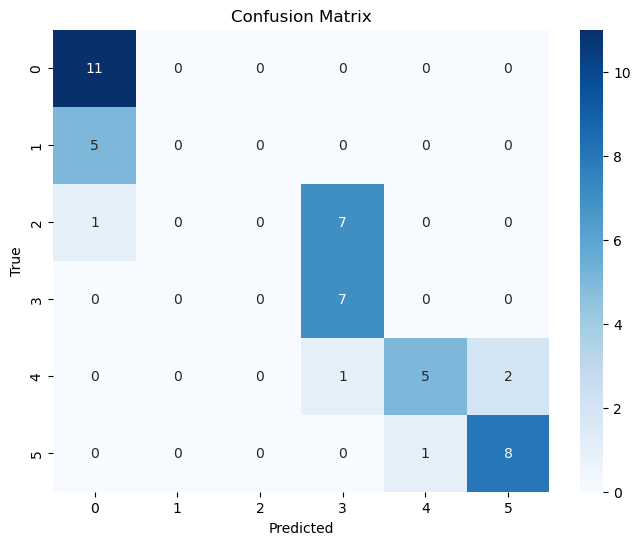

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         8
           3       0.47      1.00      0.64         7
           4       0.83      0.62      0.71         8
           5       0.80      0.89      0.84         9

    accuracy                           0.65        48
   macro avg       0.46      0.59      0.50        48
weighted avg       0.51      0.65      0.55        48



In [461]:
# Benchmarking: HR Diagram and Model Accuracy
yPred = model.predict([x_num_test, x_col_test, x_spec_test])
yPred_classes = yPred.argmax(axis = 1)

# Print Accuracy, Confusion matrix, and classification report
accuracy = accuracy_score(y_test, yPred_classes)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_test, yPred_classes)
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, yPred_classes, zero_division = 0))   

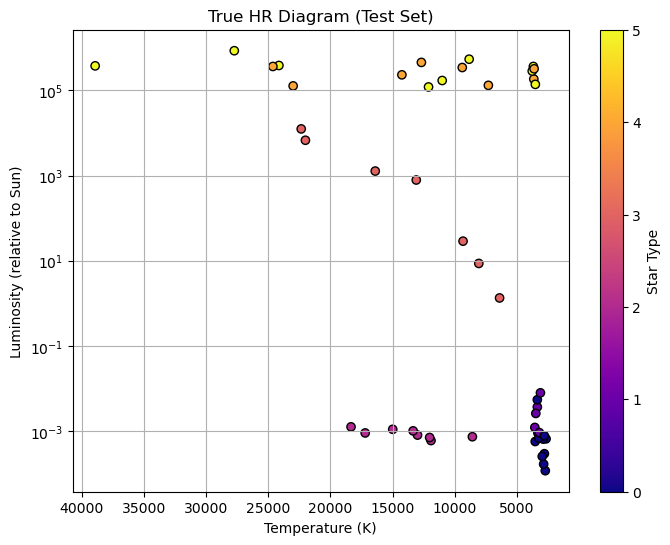

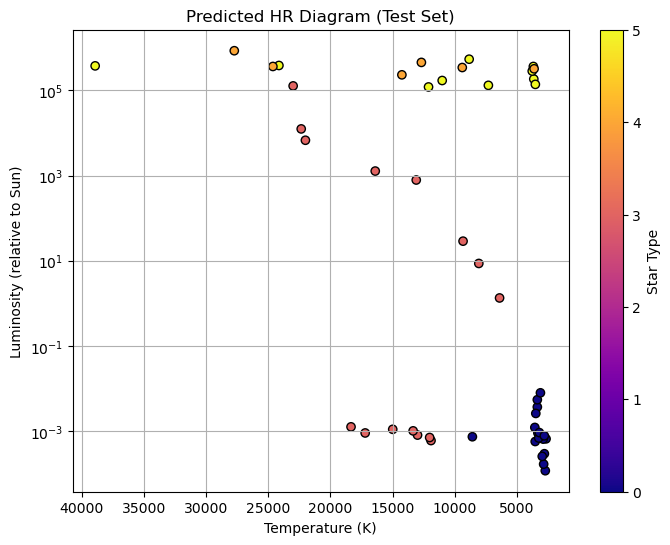

In [462]:
# Plot true and predicted Hertzsprung-Russell Diagram based off benchmark results
def plotHRPhysical(x_scaled, y, title):
    # Reverse scaling for temperature and luminosity
    temp_mean, temp_std = 10497.4625, 9532.5034
    lum_mean, lum_std = 107188.3616, 179058.0376
    temperature = x_scaled[:, 0] * temp_std + temp_mean
    luminosity = x_scaled[:, 1] * lum_std + lum_mean
    plt.figure(figsize = (8, 6))
    scatter = plt.scatter(temperature, luminosity, c = y, cmap = "plasma", edgecolor = "k")
    plt.yscale("log")
    plt.gca().invert_xaxis()
    plt.colorbar(scatter, label = "Star Type")
    plt.xlabel("Temperature (K)")
    plt.ylabel("Luminosity (relative to Sun)")
    plt.title(title)
    plt.grid(True)
    plt.show()

plotHRPhysical(x_num_test, y_test, "True HR Diagram (Test Set)")
plotHRPhysical(x_num_test, yPred_classes, "Predicted HR Diagram (Test Set)")

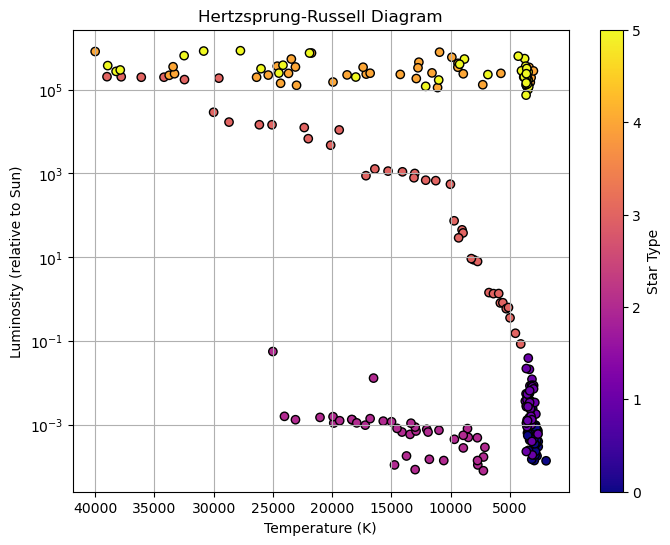

In [463]:
# Plot Hertzsprung-Russell Diagram for comparison
def plotHR(x, y, title, log = ""):
    plt.figure(figsize = (8, 6))
    if isinstance(log, str):
        scatter = plt.scatter(x[:, 0], x[:, 1], c = y, cmap = "plasma", edgecolor = "k")
    else:
        scatter = plt.scatter(x, log, c = y, cmap = "plasma", edgecolor = "k")
        plt.yscale("log")
    plt.gca().invert_xaxis() 
    plt.colorbar(scatter, label = "Star Type")
    plt.xlabel("Temperature (K)")
    plt.ylabel("Luminosity (relative to Sun)")
    plt.title(title)
    plt.grid(True)
    plt.show()
plotHR(StarData["temperature"], StarData["starType"], "Hertzsprung-Russell Diagram", StarData["luminosity"])

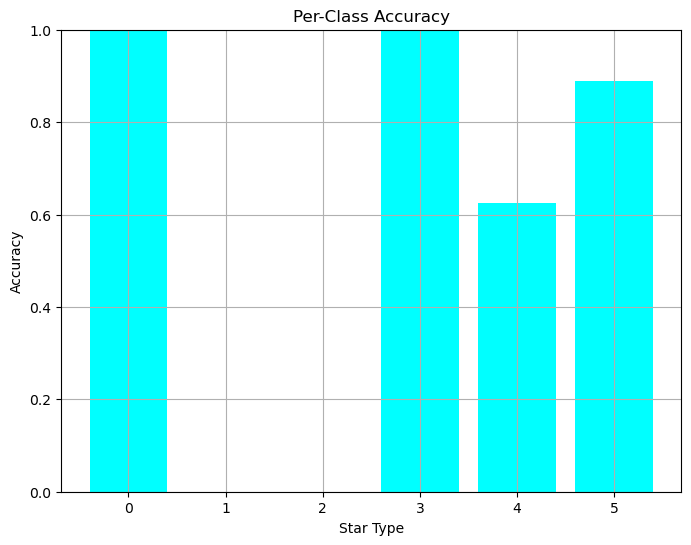

In [464]:
# Per-class accuracy calculation
classAccuracies = []
uniqueClasses = np.unique(y_test)

for i in uniqueClasses:
    j = y_test == i
    classAccuracies.append(np.mean(yPred_classes[j] == y_test[j]))
    

# Bar chart for per-class accuracy
plt.figure(figsize = (8, 6))
plt.bar(range(len(uniqueClasses)), classAccuracies, tick_label = uniqueClasses, color = "cyan")
plt.ylim(0, 1)
plt.xlabel("Star Type")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.grid(True)
plt.show()